In [1]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics
from segment_anything import sam_model_registry, SamPredictor
import sys
import segmentfunction
import utils
import math
import time


done


(128, 128, 128)


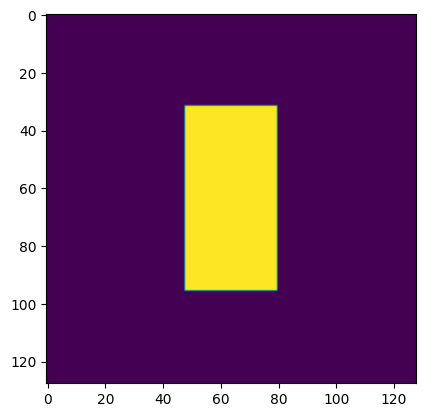

In [2]:
# configuration

starttime = time.time()
checkpointfilepath = r"C:\\Users\\aarus\\Downloads\\sam_vit_h_4b8939.pth"
num_slices = 20
transform_list = platonics.get_cube_transforms()

test_1 = np.zeros((128, 128, 128))
test_1[32:96, 48:80, 32:96] = 200
test_2=np.ones((128,128,128))
for i in range(128):
    for j in range(128):
        for k in range(128):
            if ((i-64)**2+(j-64)**2+(k-64)**2)**0.5>50:
                test_2[i,j,k]=0
                

plt.imshow(test_1[:,:,64])

image = test_1
print(image.shape)

In [3]:
def get_prompt_slices(image):
    slices_list = []
    for a, t in enumerate(transform_list):
        transformed_img = scale_transform.global_to_local(image, t)
        slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
        cv2.imwrite(f'slices_for_prompting/slice_{a}.png', slice_transformed_img)

        slice_info = dict()
        slice_info['idx'] = transformed_img.shape[2]//2
        slice_info['transform'] = t
        slice_info['shape'] = transformed_img.shape
        slices_list.append(slice_info)    

    return slices_list

def get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices):
    pos_seg = []
    neg_seg = []

    for i, s in enumerate(slices_list):
        idx = s['idx']
        shape = s['shape']
        transform_curr = s['transform']
        print(i)

        for line in pos_polylines_slices[i]:
            global_line = []
            for point in line:
                scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
                transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                pos_seg.append([global_line[j], global_line[j + 1]])

        for line in neg_polylines_slices[i]:
            if i == 1:
                print(line)
            global_line = []
            for point in line:
                scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
                transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                neg_seg.append([global_line[j], global_line[j + 1]])
    
    return pos_seg, neg_seg

def get_intersections(matrix_shape, pos_seg, neg_seg, t, z):
    # calculate intersection points
    pos_intersects = []
    neg_intersects = []

    for p in pos_seg:
        point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(p[0], t, matrix_shape), matrix_shape)
        point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(p[1], t, matrix_shape), matrix_shape)

        intersection = scale_transform.get_intersection_point(point_1, point_2, z)
        if intersection:
            pos_intersects.append(intersection[:2])

    for n in neg_seg:
        point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(n[0], t, matrix_shape), matrix_shape)
        point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(n[1], t, matrix_shape), matrix_shape)

        intersection = scale_transform.get_intersection_point(point_1, point_2, z)
        if intersection:
            neg_intersects.append(intersection[:2])
    
    return pos_intersects, neg_intersects

def normalize (image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    stacked = np.stack([image, image, image], axis=2)
    return stacked


In [4]:
# get prompt slices
folder = r"C:\Users\aarus\Downloads\slices_for_prompting\I1351301"

# image = utils.load3dmatrix(folder)
# print(image.shape)
# cube = utils.padtocube(image)
# print(cube.shape)

# slices_list = get_prompt_slices(cube)

slices_list = get_prompt_slices(image)

In [5]:
print(image.shape)

(128, 128, 128)


In [6]:
# given json with polylines
# parse
with open('data.json', 'r') as file:
    prompt_points = json.load(file)
pos_polylines_slices = []
neg_polylines_slices = []

for prompt in prompt_points:
    pos_polylines_slices.append(prompt['pos_polylines'])
    neg_polylines_slices.append(prompt['neg_polylines'])

# get pos, neg line segments
pos_seg, neg_seg = get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices)

0
1
[[31, 127, 0], [23, 157, 0], [64, 185, 0], [164, 191, 0], [185, 158, 0]]
2
3


In [7]:
print(pos_seg)

[[array([124.,  95., 124.]), array([113.,  95.,  84.])], [array([113.,  95.,  84.]), array([111.,  94.,  73.])], [array([111.,  94.,  73.]), array([ 96., 118.,  80.])], [array([ 96., 118.,  80.]), array([ 91., 125.,  81.])], [array([ 91., 125.,  81.]), array([100., 126., 119.])], [array([112., 118., 141.]), array([122., 102., 136.])], [array([107., 119.,  74.]), array([ 98., 104.,  81.])], [array([ 98., 104.,  81.]), array([91., 94., 82.])], [array([91., 94., 82.]), array([ 96.,  93., 106.])], [array([ 96.,  93., 106.]), array([104.,  94., 129.])], [array([104.,  94., 129.]), array([108.,  93., 147.])], [array([108.,  93., 147.]), array([128., 125., 137.])], [array([128., 125., 137.]), array([119., 123., 109.])], [array([119., 123., 109.]), array([113., 125.,  81.])], [array([144., 101., 106.]), array([138., 125.,  91.])], [array([138., 125.,  91.]), array([104., 126.,  99.])], [array([104., 126.,  99.]), array([ 76., 125., 107.])], [array([ 76., 125., 107.]), array([ 86.,  94., 127.])

In [8]:
# initialize the model
sam_checkpoint = checkpointfilepath
model_type = "vit_h"
# device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
predictor = SamPredictor(sam)

In [9]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  124.32050815898681
min points =  97.0688211308833


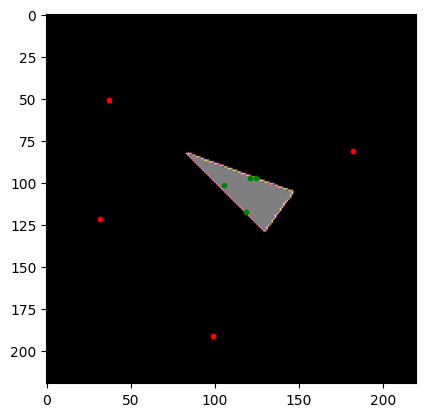

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  135.95487561383675
min points =  84.05068259294754


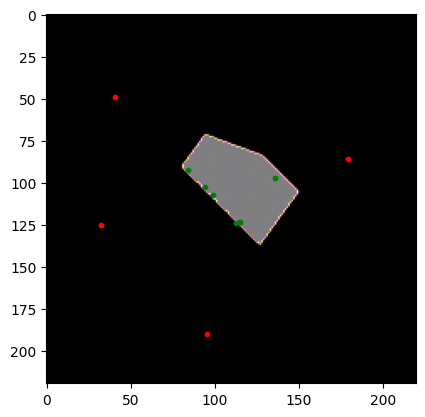

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  136.27987986772067
min points =  85.28730592076684


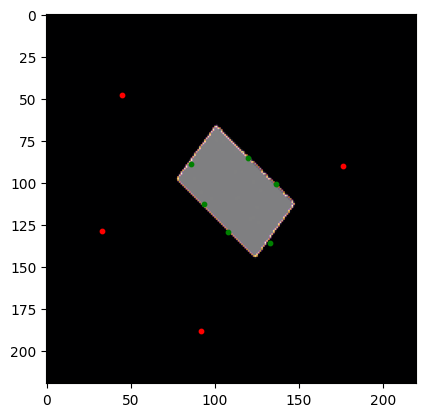

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  134.3818343162634
min points =  84.94198726428613


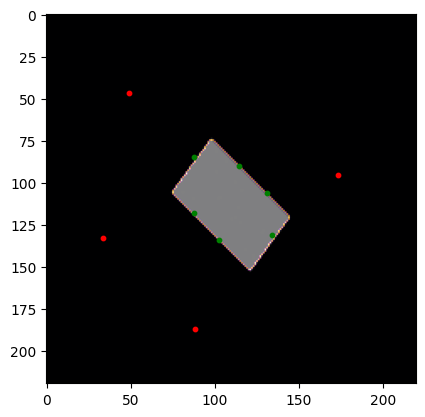

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  138.88666828926475
min points =  81.44885712441045


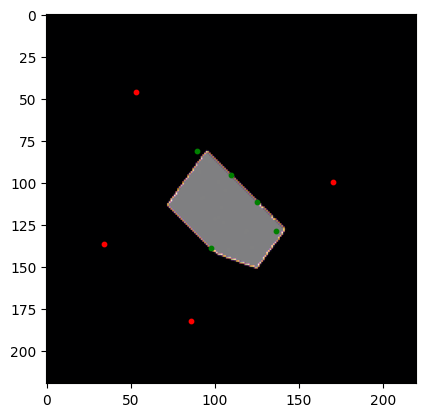

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  119.16944983531974
min points =  99.04445157345901


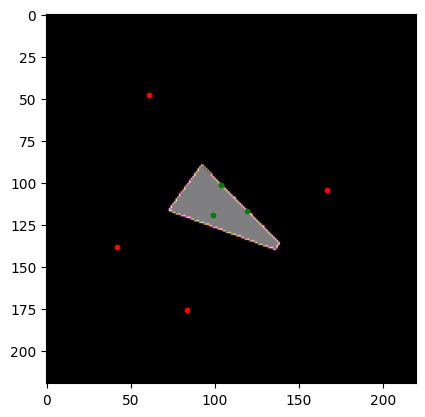

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  119.78516314493555
min points =  95.58155015093827


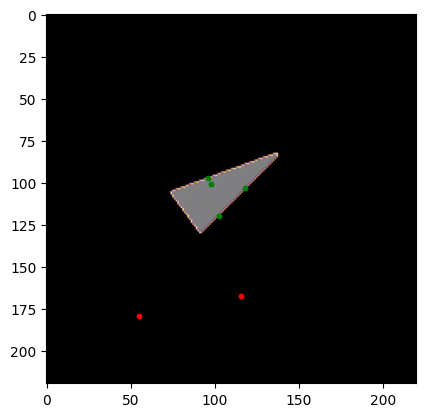

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  139.39472810638597
min points =  81.07642732784895


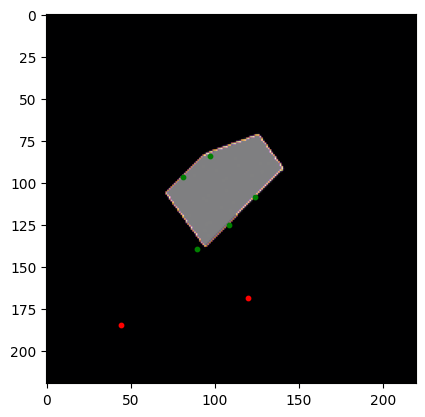

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  135.99427545015192
min points =  85.51790144735386


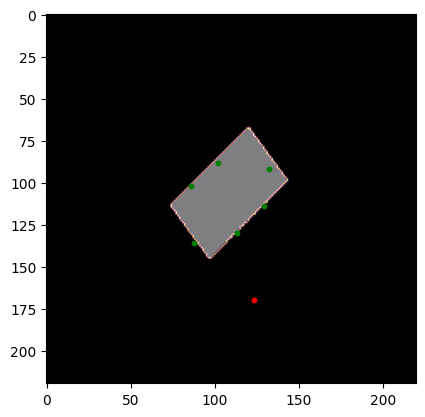

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  134.77960478461875
min points =  85.5010732071697


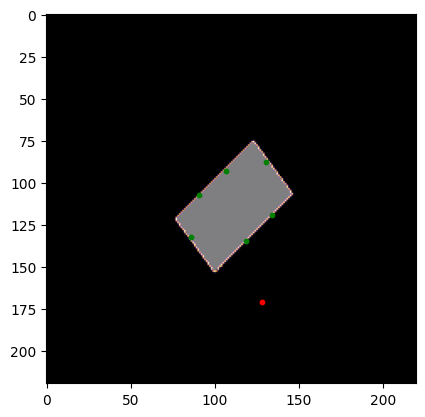

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  139.2801324611776
min points =  83.15767692465646


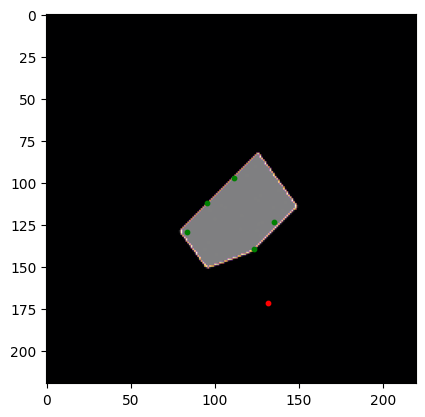

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  122.93848378359634
min points =  101.27856863391999


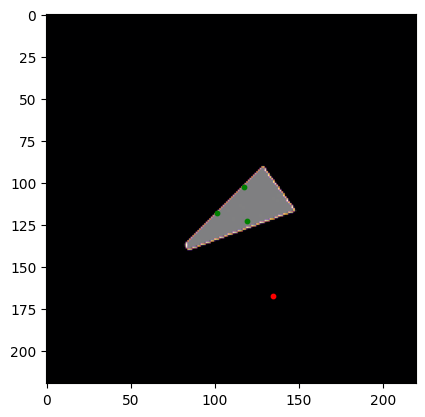

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  122.78771793446975
min points =  107.3779146179872


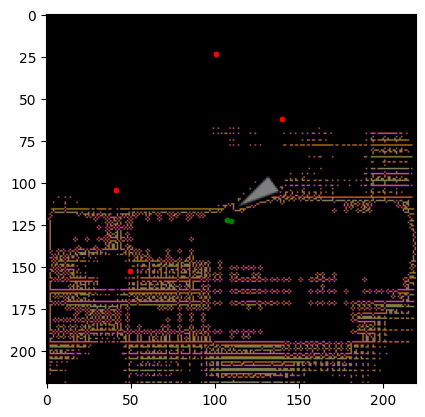

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  124.5319700971951
min points =  100.99900900386068


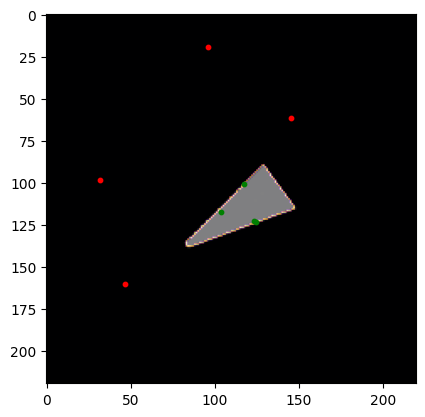

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  138.77507450821915
min points =  85.77043478251889


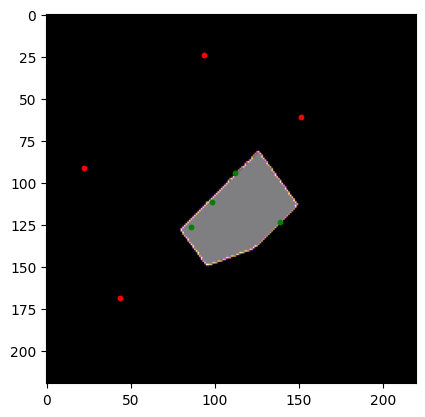

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  134.29077520118284
min points =  87.10740301620606


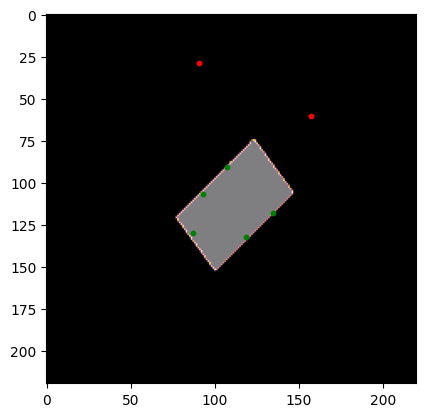

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  134.08094255399357
min points =  86.0168593212972


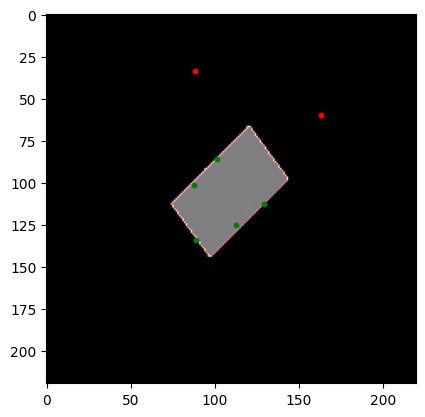

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  136.23410985544166
min points =  80.02944707125398


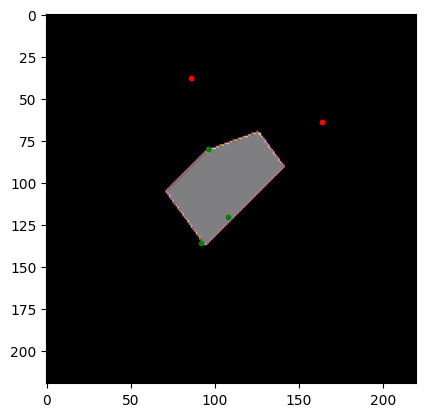

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  116.49310256302057
min points =  94.71851706658452


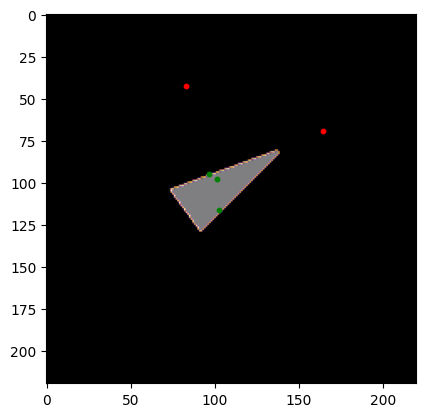

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  124.4004059125712
min points =  95.94647567614915


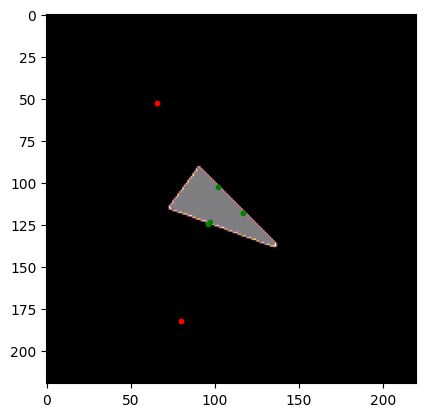

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  138.64813825315122
min points =  80.21357226961727


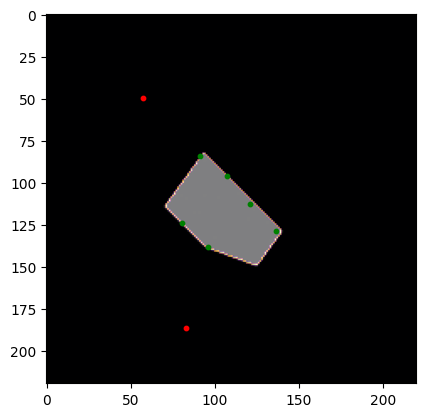

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  134.13716987107986
min points =  84.31713678411754


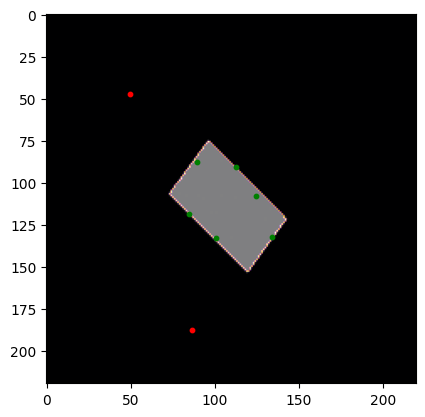

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  135.77752324742764
min points =  87.45919654826625


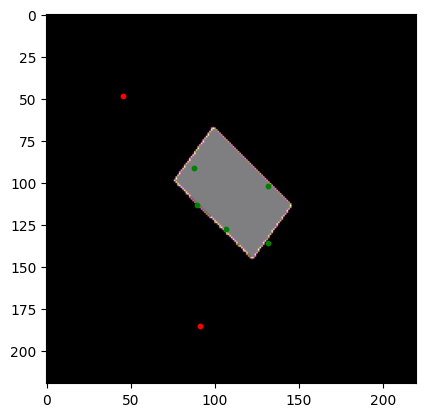

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  137.6697709748773
min points =  85.84268894120807


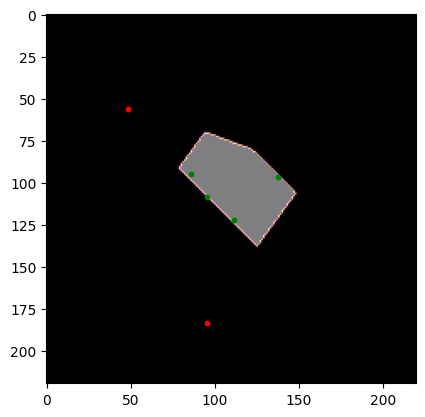

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  124.68015447499555
min points =  96.64240657453794


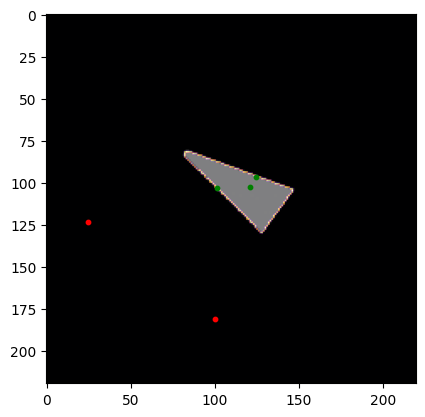

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  110.16251670194447
min points =  97.16405844204968


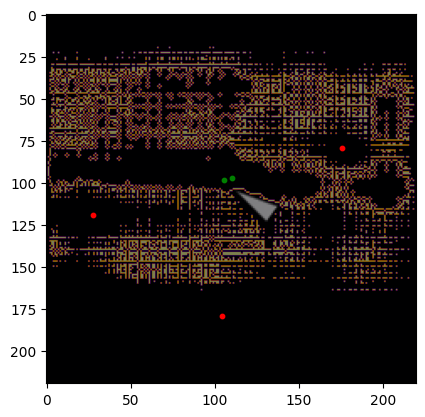

[array([0.14171325, 0.28342649, 0.28342649]), array([0.14696188, 0.27817785, 0.27817785]), array([0.15221052, 0.27292921, 0.27292921]), array([0.15745916, 0.26768057, 0.26768057]), array([0.14171325, 0.28009899, 0.27100808]), array([0.14696188, 0.27485035, 0.26575944]), array([0.15221052, 0.26960171, 0.2605108 ]), array([0.15745916, 0.26435307, 0.25526216]), array([0.1627078 , 0.25910443, 0.25001352]), array([0.14171325, 0.27677148, 0.25858967]), array([0.14696188, 0.27152284, 0.25334103]), array([0.15221052, 0.26627421, 0.24809239]), array([0.15745916, 0.26102557, 0.24284375]), array([0.1627078 , 0.25577693, 0.23759511]), array([0.16795644, 0.25052829, 0.23234647]), array([0.17320508, 0.24527965, 0.22709783]), array([0.14171325, 0.27344398, 0.24617125]), array([0.14696188, 0.26819534, 0.24092261]), array([0.15221052, 0.2629467 , 0.23567398]), array([0.15745916, 0.25769806, 0.23042534]), array([0.1627078 , 0.25244943, 0.2251767 ]), array([0.16795644, 0.24720079, 0.21992806]), array([0.

In [13]:
# BIG forloop
prompting_slices_dict = dict()
count = 0
allpoints = []

for t in transform_list:
    transformed_img = scale_transform.global_to_local(image, t)
    matrix_shape = transformed_img.shape
    
    z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:]  

    for z in z_coord_list:
        # get the slice of the rotated array
        slice_transformed_img = transformed_img[:,:,z]
        slice_shape = slice_transformed_img.shape
        
        pos_intersects, neg_intersects = get_intersections(matrix_shape, pos_seg, neg_seg, t, z)
        # print("posintersects = ", pos_intersects)
        # print("negintersects = ", neg_intersects)

        # maybe we dont need
        if len(pos_intersects) != 0:
            prompt = [pos_intersects, neg_intersects]
            for i in range(len(prompt)):
                for j in range(len(prompt[i])):
                    prompt[i][j] = (prompt[i][j][1], prompt[i][j][0])
            points, boundary = segmentfunction.segment(predictor, normalize(slice_transformed_img), 0, prompt)
            pointstobeconverted = []
            for a in range(points.shape[0]):
                for b in range(points.shape[1]):
                    if points[a,b] == 1:
                        pointstobeconverted.append([a,b,z])
            # print(pointstobeconverted)
            
            convertedpoints = [scale_transform.index_to_coord(p, t, matrix_shape) for p in pointstobeconverted]
            for i in convertedpoints:
                # print(i)
                # print(type(i))
                allpoints.append(i)

print(allpoints)



In [14]:
pcd = o3d.geometry.PointCloud()
n = np.zeros((len(allpoints), 3))
for i in range(len(allpoints)):
    n[i] = allpoints[i]
pcd.points = o3d.utility.Vector3dVector(n)
print("Time taken = ", time.time()-starttime)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")


Time taken =  29302.417699098587
